## Options Backtesting Framework

This is a simple backtesting framework for options. Given end of day data for both the capital and derivatives markets, we would be backtesting for different strategies.

> All options are opened at the start of the period and closed by the end of the period or by a stop loss if provided

### Implementation

1. Load and transform necessary data
2. Create a list of option contracts to be entered into each day
3. Create a list of signals, on whether to enter into the contract, for each day
4. Extract the necessary data for the options contracts that would be executed
5. Analyze Profit and loss and other metrics


In [107]:
# Load necessary libraries

import pandas as pd
import numpy as np

import seaborn as sns
sns.set()

## Utility Functions

In [101]:
def itm(price, opt='C', step=100):
    """
    Get the strike price of the in the money option
    price
        spot price
    opt
        option type - C for Call and P for Put
    step
        multiple of option strike price
    """
    if opt == 'C':
        return int(price/step)*step
    elif opt == 'P':
        return (int(price/step)+1)*step

Data Preparation
-----------------
Load the raw data and do some transformations. All raw options data is loaded from the bhav copy of the NSE website. Index data is from [niftyindices.com](https://www.niftyindices.com/).

In [102]:
nifty = pd.read_csv('/home/machine/Downloads/NIFTY 50_Data.csv',
                   parse_dates=['Date'])
nifty.rename(lambda x: x.lower(), axis='columns', inplace=True)
nifty = nifty[nifty.date.dt.year==2019].sort_values(by='date').reset_index(drop=True)

der = pd.read_hdf('/media/machine/4E1EA2D152455460/data/output/fno_2019.h5')
der.rename({'timestamp': 'date'}, axis='columns', inplace=True)
der['exp_day'] = der.expiry_dt.dt.day

# Difference between expiry date and date
der['day_diff'] = (der['expiry_dt'] - der['date']).dt.days


In [103]:
# Change your symbol here
symbol = 'NIFTY'
# Keep nifty data with monthly options only
# This hack is incomplete and should be correctly configured
q = '(symbol=="{sym}") & (instrument=="OPTIDX") & (exp_day > 24) & (day_diff<29)'
df = der.query(q.format(sym=symbol))
pd.Series(df.expiry_dt.unique()).sort_values()

4   2019-01-31
1   2019-02-28
2   2019-03-28
0   2019-04-25
3   2019-05-30
5   2019-06-27
dtype: datetime64[ns]

Select list of options
-----------------------

We must now select the list of options to be traded. To begin, with let's BUY in the money call option at the start of the day and hold it till the end of the day. We need the following columns for each day

 * date
 * strike price
 * option_type
 * spot price

In [116]:
def option_prices(prices, opt=[('C',0)], step=100):
    """
    Get the list of options for each period
    prices
        prices on which the option prices are to be generated
        series with date as index and price as values
    opt
        list of option type and step as 2-tuples
            * (C,0) mean in-the-money call option
            * (C,1) mean call option next to in-the-money
            * (P,0) mean in-the-money put option
    step
        optional step size for the option
    Note
    -----
    All calculations are done with in-the-money option
    as the reference point. To illustrate, assume a spot price of 10285
    (C,0) -> 10200
    (C,1) -> 10300
    (P,0) -> 10300
    (P,1) -> 10200
    (C,0) with step=50 -> 10250
    (C,1) with step=50 -> 10300
    """
    collect = []
    s = prices.reset_index()
    s.columns = ['date', 'spot']
    for opt, strk in opt:
        o = s.copy()
        o['strike_pr'] = [itm(x)+(strk*step) for x in nifty.open]
        if opt == 'C':
            o['option_typ'] = 'CE'
        elif opt == 'P':
            o['option_typ'] = 'PE'
        collect.append(o)
    return pd.concat(collect)

In [104]:
nifty['strike_pr'] = [itm(x) for x in nifty.open]
nifty['spot'] = nifty.open.copy()
nifty['option_typ'] = 'CE'
cols = ['date', 'strike_pr', 'option_typ', 'spot']
options = nifty[cols].copy()
options.head()

,date,strike_pr,option_typ,spot
0,2019-01-01,10800,CE,10881.70
1,2019-01-02,10800,CE,10868.85
2,2019-01-03,10700,CE,10796.80
3,2019-01-04,10600,CE,10699.70
4,2019-01-07,10800,CE,10804.85


In [117]:
options = option_prices(nifty.set_index('date').open)
options.head()

,date,spot,strike_pr,option_typ
0,2019-01-01,10881.70,10800,CE
1,2019-01-02,10868.85,10800,CE
2,2019-01-03,10796.80,10700,CE
3,2019-01-04,10699.70,10600,CE
4,2019-01-07,10804.85,10800,CE


Select signals
--------------

A signal is a indication whether to buy or sell the contract on a daily basis. It is a single column that outputs 1 if the contract is entered into or a 0 if the contract is not entered. Since we would be trading for all the days, we simply include a 1 for all dates

In [105]:
options['signal'] = 1
options.head()

,date,strike_pr,option_typ,spot,signal
0,2019-01-01,10800,CE,10881.70,1
1,2019-01-02,10800,CE,10868.85,1
2,2019-01-03,10700,CE,10796.80,1
3,2019-01-04,10600,CE,10699.70,1
4,2019-01-07,10800,CE,10804.85,1


Merging data and backtesting
-----------------------------
Since we have restricted the data at the time of query to only contracts with monthly expiry and to a particular symbol, there would be only one contract with the specific strike and option type on a particular date. So we could go ahead with a simple merge


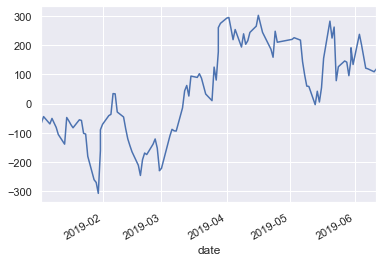

In [120]:
cols = ['symbol', 'date', 'expiry_dt', 'strike_pr', 'option_typ',
       'open', 'high', 'low', 'close']
res = options.merge(df[cols], on=['date', 'strike_pr', 'option_typ'])
res['profit'] = res.eval('close-open') # to change in case of selling options
res['cum_profit'] = res.profit.cumsum()
res.set_index('date').cum_profit.plot()

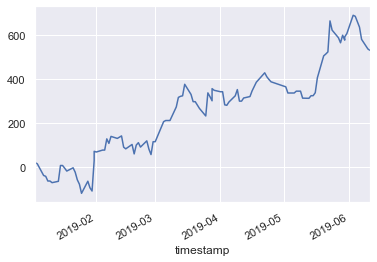

In [124]:
# Run a backtest with stop loss and price set
# pip install fastbt for this to work

from fastbt.rapid import backtest
df101 = options.merge(df[cols], on=['date', 'strike_pr', 'option_typ'])
df101['timestamp'] = df101['date']
results = backtest(data=df101, stop_loss=25, order='B', price='open*1.1')
results['profit'] = results.eval('sell-buy')
results.set_index('timestamp').profit.cumsum().plot()

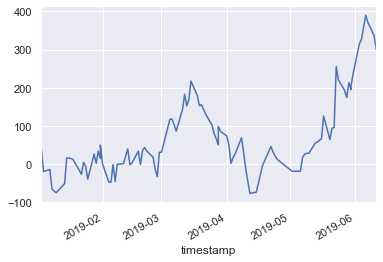

In [126]:
results = backtest(data=df101, stop_loss=25, order='S', price='open*0.9')
results['profit'] = results.eval('sell-buy')
results.set_index('timestamp').profit.cumsum().plot()

Let's work out a slightly complex option
